### PA602/PA2605/PA2606: Intermediate Climate Science
# Computer Workshop 4

#### Todays Objectives:
1. Further develop our understanding of satellite remote sensing by developing a temperature profile retrieval algorithm for HIRS
2. We use sythnetic data (produced with a radiative transfer model) to develop our algorithm
3. Assess our algorithm perfomance against i) a small subset of the synthetic data (verifying our retrieval), and ii) against GRUAN radiososndes (validation)
4. **Research question**: Can we identify air parcel stability from these profiles?
5. Begin to set out the Jupyter notebook for your course work analysis with the common datasets, and code blocks
6. Review the marking criteria   

#### Python Libraries
For all our computer workshsops we will work with four python libraries:
1. **NumPy** (https://numpy.org/): _"NumPy is the fundamental package for scientific computing in Python. It is a Python library that provides a multidimensional array object, various derived objects (such as masked arrays and matrices), and an assortment of routines for fast operations on arrays, including mathematical, logical, shape manipulation, sorting, selecting, I/O, discrete Fourier transforms, basic linear algebra, basic statistical operations, random simulation and much more"_. We will use this for most of our math functions
2. **SciPy** (https://scipy.org/): _"SciPy is a collection of mathematical algorithms and convenience functions built on NumPy . It adds significant power to Python by providing the user with high-level commands and classes for manipulating and visualizing data"_.This is the other library we wil use for statistical/algorithmic functions.
3. **NetCDF4** (https://unidata.github.io/netcdf4-python/): The Network Common Data Form (NetCDF) is specific scientific data format used in climate and earth observation sciences. Each variable is stored in a compressed format along with accompanying meta data. The majority of data you will use in this course wil be stored in this format.
4. **Matplotlib** (https://matplotlib.org/): _"Matplotlib is a comprehensive library for creating static, animated, and interactive visualizations in Python. Matplotlib makes easy things easy and hard things possible"_. We will use this library to visualise the contents of data files and the results from the analyses we perform on these data.

In [1]:
# lets import our libraries here
import matplotlib.pyplot as plt
import numpy as np
import netCDF4

***
# Exersise 1: Developing a Linear Temperature Profile Retrieval Algorithm

## Last time in lecture 4 we covered ...

![](img/linRetLect4Slide1.png)

***

![](img/linRetLect4Slide2.png)

### Task 1: Develop our inverse linear operator 

![](img/workflow_step1.png)

In the data folder you will se that there is some prepared data for this task

![](img/workflow_step2.png)

- Now we want to read this data into memory
- Like in previous workshops we can add our <span style="color:blue">**read_gridded_data()**</span> function in the cell below and then read the data into memory
***

In [2]:
def read_gridded_data(filename, report=True):
    """ function to read regular gridded data files and return a Python dictionary.
    inputs: filename -> name of file to be read
            report   -> boolean flag, if true then a table listing the file contents is printed to screen

    outputs: data    -> a python dictionary containing the file contents
    """
    # open the file and map the contents to a netCDF object. Use a test to capture
    # any issues with the data file
    try:
        nc = netCDF4.Dataset(filename,"r")
    except IOError:
        raise
    # if report is set to true then prind global attributes
    if report == True:
        print(f"Global Attributes For File: {filename}") # when witing strings, starting them with an 'f' allows you to insert other variables using {}.
        print("----------------------------------------------------------------------------------------------------")
        print(nc)
    # Define a dictionary to hold the contents
    data = {} 
    # loop over the file contents and write
    if report == True:
        # what variables are in this file?
        # printing Aligned Header 
        print("-------------------------------------------------------------------")        
        print(f"{'Variable Name' : <14} |{'Long Name':<32} |{'tdim, ydim, xdim':>17}") 
        print("-------------------------------------------------------------------")
    else:
        pass # we add a pass so we can close this if statement with an else

    for varname in nc.variables.keys():
        if report == True:
            print(f"{varname:<14} |{nc[varname].long_name:<32} |{', '.join([str(d) for d in nc[varname].shape]):>17}")
        else:
            pass
        # write the variable to the dictionary
        data[varname] = nc[varname][:] #  the [:] at the end indexes all the data
    
    # finally close the file
    nc.close()

    # return the filled data dictionary
    return data

In [3]:
# now reads the data into memory
                  
filelist = ["data/hirs_lin_ret_clr_sky_inputs_rttov_bts_atm_tmp_profiles_01.nc",
            "data/hirs_lin_ret_clr_sky_inputs_rttov_bts_atm_tmp_profiles_02.nc",
            "data/hirs_lin_ret_clr_sky_inputs_rttov_bts_atm_tmp_profiles_03.nc",
            "data/hirs_lin_ret_clr_sky_inputs_rttov_bts_atm_tmp_profiles_04.nc",
            "data/hirs_lin_ret_clr_sky_inputs_rttov_bts_atm_tmp_profiles_05.nc",
            "data/hirs_lin_ret_clr_sky_inputs_rttov_bts_atm_tmp_profiles_06.nc",
            "data/hirs_lin_ret_clr_sky_inputs_rttov_bts_atm_tmp_profiles_07.nc",
            "data/hirs_lin_ret_clr_sky_inputs_rttov_bts_atm_tmp_profiles_08.nc"]

for ii, filename in enumerate(filelist):
    if ii == 0:
        sim_data = read_gridded_data(filename, report=True)
    else:
        tmp = read_gridded_data(filename, report=False)
        for vname in tmp.keys():
            sim_data[vname] = np.vstack([sim_data[vname], tmp[vname]])
        del tmp
        

Global Attributes For File: data/hirs_lin_ret_clr_sky_inputs_rttov_bts_atm_tmp_profiles_01.nc
----------------------------------------------------------------------------------------------------
<class 'netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    title: RTTOV training data file
    institution: University of Leicester
    history: File created using software developed at University of Leicester
    id: hirs_lin_ret_clr_sky_inputs_rttov_bts_atm_tmp_profiles_01.nc
    date_created:  2025-03-04 17:54:02
    product_version: 1.0
    creator_name: Tim Trent
    creator_email: tjt11@le.ac.uk
    dimensions(sizes): nsoundings(54000), nchannels(12), nlevels(60)
    variables(dimensions): float32 pres(nsoundings, nlevels), float32 T(nsoundings, nlevels), float32 bts(nsoundings, nchannels)
    groups: 
-------------------------------------------------------------------
Variable Name  |Long Name                        | tdim, ydim, xdim
-------------------------------

***
![](img/workflow_step3.png)

- now we can define the processes we what to impliment
  1. Split the data into a training and evalution (test) sets.
  2. Impliment the ability to use the whole of the training data or randomly sample the training data based on a fraction of the total number of soundings.
  3. Calculate the covariance of the BT observations ($y^{T}y$)
  4. Calculate covariance of the BT observations with the temperature profiles ($y^{T}T$)
  5. Calculate the inverse linear operator ($M^{[-1]}$)
- Finally, we want create a set of temperature profile estimates from oour test set which we can the evaluate 

In [4]:
# 1. split the data into test and training datasets
bts_train = sim_data['bts'][0:-200,:] # remove the first 200 soundings
T_train = sim_data['T'][0:-200,:]     # remove the first 200 temperature profiles
p_train = sim_data['pres'][0:-200,:]  # remove the first 200 pressure profiles
nsoundings = bts_train.shape[0]

#bts_train = np.hstack([bts_train, p_train[:,-1].reshape(nsoundings,1)])

bts_test = sim_data['bts'][-200:,:] # use the first 200 soundings
T_test = sim_data['T'][-200:,:]     # use the first 200 temperature profiles
p_test = sim_data['pres'][-200:,:]  # use the first 200 pressure profiles

#bts_test = np.hstack([bts_test, p_test[:,-1].reshape(200,1)])

# print out how many soundinghs are in the training data set
print(f" we have {nsoundings:,} simulated soundings in the training dataset")

 we have 431,800 simulated soundings in the training dataset


In [5]:
# 2. impliment the sampling of the training data, we also use random asigment of the indexes to mix the data
#===========================================================================================================
# default: 65% of the sounidngs in the training data
frac = 0.65 
 # convert that to an integer value
num = int(nsoundings*frac)
# randomly sample the training data
index = np.random.choice(nsoundings, num, replace=False) 
print(f"we are going to build our inverse linear regression operator with {index.size:,} soundings")

we are going to build our inverse linear regression operator with 280,670 soundings


Text(0.5, 1.0, '$y^{T}y$ (12 x 12)')

<Figure size 600x600 with 0 Axes>

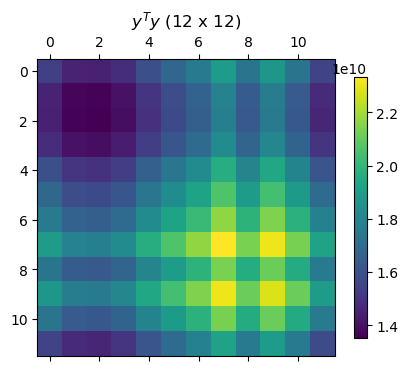

In [6]:
# 3. Calculate a covariance of the brightness temperatures y^Ty
#==============================================================
# lets add the abilty to select different channels, though the default will be for all 12
ch_idx = np.array([0,1,2,3,4,5,6,7,8,9,10,11])

# uncomment to test different channel selection
#ch_idx = np.array([0,2,4,6,8,10]) # add your selection, example only even integers 

# we convert the arrays to matricies so we can apply transpose and invert methods to the data
y = np.matrix(bts_train[index,:][:,ch_idx]) # first we index the soundings based on the random sampling [index,:]
                                            # then the channels [:,ch_idx]

# calculate the covariance
yTy = y.T * y # y.T performs a transpose operation to the y matrix

# Lets visualise the matrix
plt.figure(figsize=(3,3),dpi=200)
plt.matshow(yTy)
plt.colorbar(shrink=0.7)
ydim, xdim = yTy.shape
plt.title(r"$y^{T}y$"+f" ({xdim} x {ydim})")

Text(0.5, 1.0, '$y^{T}T$ (60 x 12)')

<Figure size 600x600 with 0 Axes>

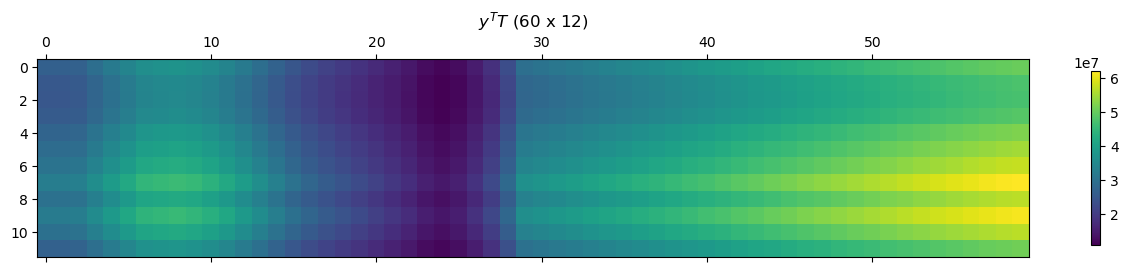

In [7]:
# 4. Calculate a covariance of the brightness temperatures and temperature profiles y^T T
#========================================================================================

# for the temperature profiles we can apply scaling to the the data (e.g. range = 0-1)
# for better stability. To do this we set a Tmin and Tmax, we can start by using the range in the data
# and adding a 1 K buffer to each end
buffer = 1 # K
Tmin = int(np.min(T_train)-buffer) 
Tmax = int(np.max(T_train)+buffer)

# apply the sounding sampling index and scale the temperature profiles
T_train_scaled = (T_train[index,:]-Tmin)/(Tmax-Tmin)

# convert to the matrix
T_scl = np.matrix(T_train_scaled)

# calculate the covaraince
yTT = y.T * T_scl

# Lets visualise the matrix
plt.figure(figsize=(3,3),dpi=200)
plt.matshow(yTT)
plt.colorbar(shrink=0.7)
ydim, xdim = yTT.shape
plt.title(r"$y^{T}T$ ("+f"{xdim} x {ydim})")

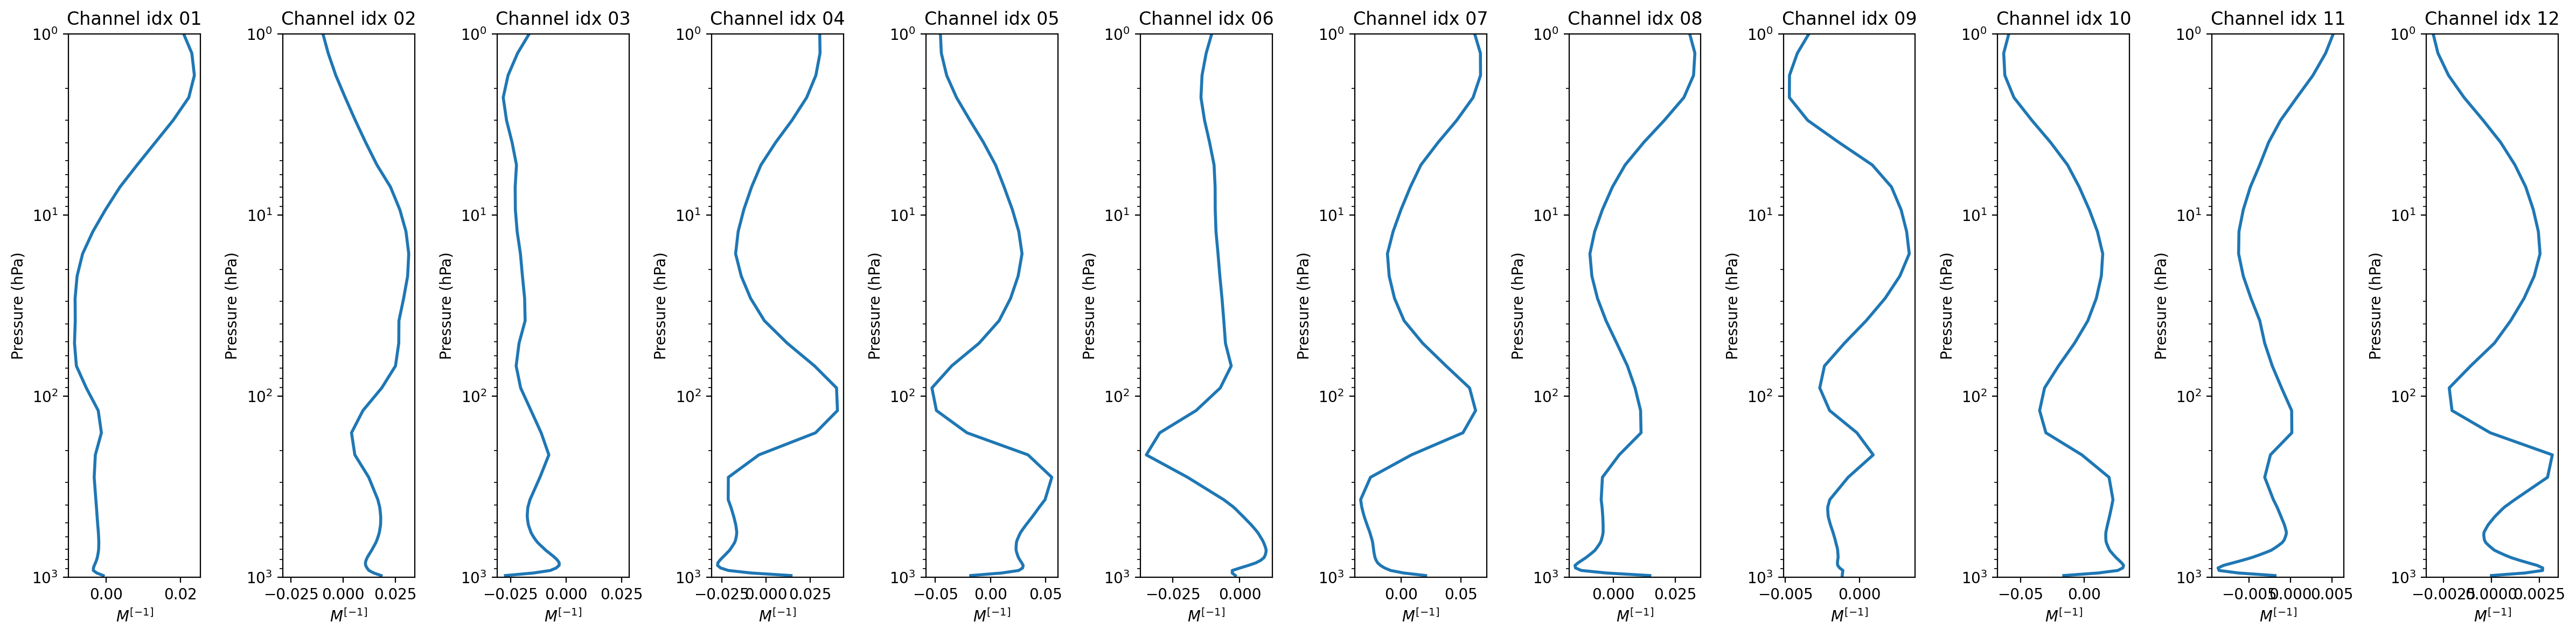

In [8]:
# 5. Calculate the inverse linear operator
Minv = yTy.I * yTT  # yTy.I cinverts the yTy matrix before doing the multiplication

# let visualise this matrix a little differently
# start by defining a figure size
fig=plt.figure(figsize=(24,6),dpi=200)
# next loop over each channel:
for ii in range(ch_idx.size):
    # define the subplot
    plt.subplot(1,ch_idx.size,ii+1)
    # first convert back to an array and plot the row of the M^[-1] matrix.
    # Here we are using the mean pressure prfoile for the y axis and setting the y axis to log scale (semilogy, similar method for x axis) 
    plt.semilogy(np.array(Minv)[ii,:], np.mean(p_train,axis=0),lw=2)
    # set y axis range
    plt.ylim(1000,1)
    # add axis labels
    plt.ylabel("Pressure (hPa)")
    plt.xlabel(r"$M^{[-1]}$")
    # add a title
    plt.title(f"Channel idx {ii+1:02}")
# optimise white space
plt.tight_layout()

### Lets use the model!
now we have created a linear operator we can apply it to our traing data. Lets create a function to do this:

In [9]:
def apply_linear_retrieval(Minv, Tmin, Tmax, bts):
    """ this function applys the inverse linear operator to a set of bightness temperatures
    and returns the retirved temperature profiles.
    inputs: Minv -> inverse linear operator
            Tmin -> minimum temperature for pfoile scaling
            Tmax -> maximum temperature for profile scaling
            bts  -> brightness temperatures

    outputs: T_est -> retrieved (estimated) temperature profiles
    """
    # use the numpy dot product to apply the inverse linear operator to 
    # the BTs. Note: we need to convert Minv back to an array for this operation
    T_est_scaled = np.dot(bts,np.array(Minv))

    # rescale the retrieved profiles back to K
    T_est = (T_est_scaled *(Tmax-Tmin))+Tmin

    # return result
    return T_est

In [10]:
# retrieve the temperature profiles for the test set of BTs
T_est = apply_linear_retrieval(Minv, Tmin, Tmax, bts_test[:,ch_idx])

***
![](img/workflow_step4.png)

- now lets evaluate our model with the test data and plot the result. To do this we will perform the following steps:
  1. Create a function to plot our results, which we can resue later
  2. plot the mean results from our model

In [11]:
def plot_T_profile_comparisons(ret_T, ref_T, p):
    """ function to create consistent profile reference plots.
    Inputs: ret_T -> retrieved T profiles from our linear algorithm
            ref_T -> reference T profiles
            p     -> common pressure grid (60 sigma levels)

    output: 2 panel plot
    """
    
    # calculate the differences between the satellite estimated, and the refeence temperature profiles
    dT = ret_T - ref_T
    # next calculate the mean and standard deviation results
    mu_dT = np.nanmean(dT, axis=0)
    sd_dT = np.nanstd(dT, axis=0)

    # define the figure size
    plt.figure(figsize=(6,3),dpi=200)

    # first subplot
    plt.subplot(121)
    # plot the mean temperature profiles using semilogy (y axis in log scale as we ain pressure coordinates) for the reference and retrieved data
    plt.semilogy(np.nanmean(ref_T,axis=0), np.nanmean(p,axis=0),'--',lw=2,color='#C55A11',label=r'Av. Truth')
    plt.semilogy(np.nanmean(ret_T,axis=0), np.nanmean(p,axis=0), '-',lw=2,color='#2E75B6',label=r"Av. Estimate")
    # set the yaxis range
    plt.ylim(1000,10)
    # add labels
    plt.ylabel("Pressure (hPa)",fontsize=14)
    plt.xlabel("Atmospheric Temperature (K)",fontsize=14)
    # add a legend
    plt.legend(loc=1,fontsize=8)

    # second subplot
    plt.subplot(122)
    # plot the mean difference profile between the retrieved and reference temperature profiles and add a dashed line for +/- 1 sigma
    plt.semilogy(mu_dT+sd_dT, np.nanmean(p,axis=0), '--', color='#1F3649',alpha=0.5,label=r"$\pm 1\sigma$")
    plt.semilogy(mu_dT-sd_dT, np.nanmean(p,axis=0), '--', color='#1F3649',alpha=0.5)
    plt.semilogy(mu_dT, np.nanmean(p,axis=0),color='#1F3649',label="mean (Estimate-Truth)")
    # set y axis range
    plt.ylim(1000,10)
    # add labels
    plt.ylabel("Pressure (hPa)",fontsize=14)
    plt.xlabel(r"$\Delta$Temperature (K)",fontsize=14)
    # add a legend
    plt.legend(loc=2,fontsize=8)
    # optimise the white space
    plt.tight_layout()

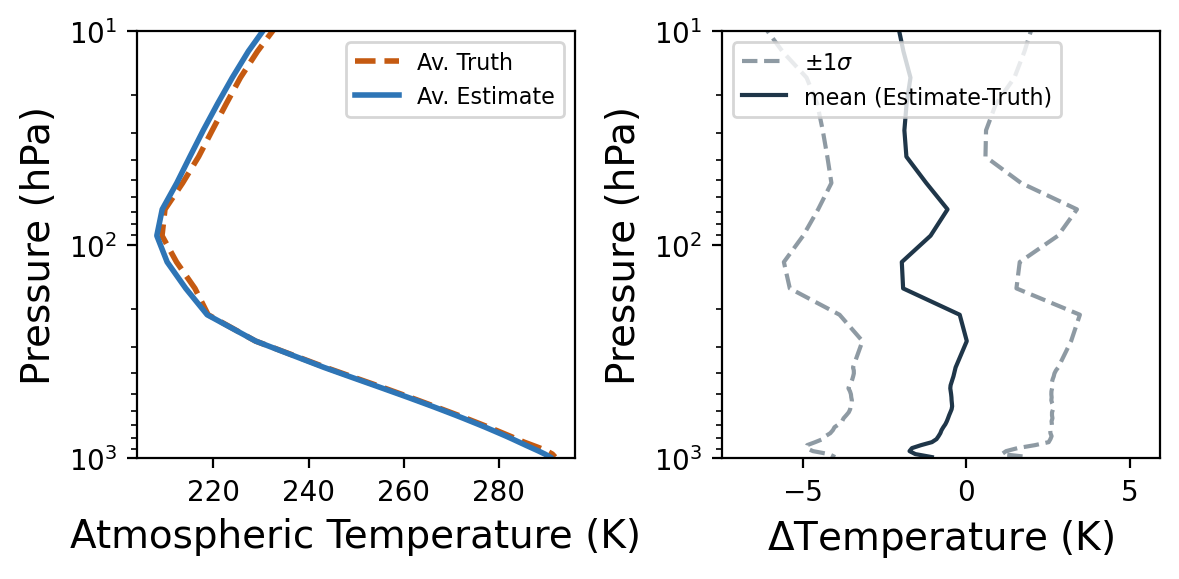

In [12]:
plot_T_profile_comparisons(T_est, T_test, p_test)

# Experiment 1 Instructions:
### Read through all bullets first before proceeding. 

- Have a go at rerunning the model a few times, do you get the same result?
- Try a few further experiments where you alter the fraction of training data you use (0 to 1), and/or the number of channels (0-11). How does the result change? 
    ```python
    # 2. impliment the sampling of the training data, we also use random asigment of the indexes to mix the data
    #===========================================================================================================
    # default: 65% of the sounidngs in the training data
    frac = 0.65 

    # 3. Calculate a covariance of the brightness temperatures y^Ty
    #==============================================================
    # lets add the abilty to select different channels, though the default will be for all 12
    ch_idx = np.array([0,1,2,3,4,5,6,7,8,9,10,11])
    
    # uncomment to test different channel selection
    #ch_idx = np.array([0,2,4,6,8,10]) # add your selection, example only even integers 
    
- From the above set of experiments, what can you conclude about the stability of linear retrievals and the representativeness of the training data?
- After each rerun, if you think the result is good run the code below to save the sampling index
    ```python
    # save the indexes for your model in case you need to start again
    with open('optimal_model_taining_data_sample_indexes.npy', 'wb') as f:
        np.save(f, index)



In [13]:
# save the indexes for your model in case you need to start again
with open('optimal_model_taining_data_sample_indexes.npy', 'wb') as f:
    np.save(f, index)

***
# Validation of our algorithm
![](img/gruan_sites.png)

- For this first exersise we are going to look at the tropospheric temperature profiles from radiosonde data collected using weather balloons and collocated with some HIRS soundings.
- The dataset we will make use of come from the Global Climate Observing System (GCOS) Reference Upper-Air Network (GRUAN) database (https://www.gruan.org/) which contains measurements from around 30 sites globally. GRUAN empose a set of standard operating proceedures on all sites that wish to qualify as part of the network (probably ~1000 radisonde sites globally).
- This ensures a calibration consistency across the network, standard characterisation of measuremnts, and production of uncertainities. Therefore, GRUAN observations are considered to be 'climate quality' data.
- A dataset has been prepared with matches at 8 sites, though some quality control of the data is still needed.

![](img/workflow_step1.png)

In the data folder you will see that there is a prepared data file for this task, collocated_hirs_bts_vs_gruan_tmp_profs.nc

![](img/workflow_step2.png)

- Now we want to read this data into memory
- we will reuse the <span style="color:blue">**read_gridded_data()**</span> function that we added earlier
***

In [14]:
matchups = read_gridded_data("data/collocated_hirs_bts_vs_gruan_tmp_profs.nc", report=True)

Global Attributes For File: data/collocated_hirs_bts_vs_gruan_tmp_profs.nc
----------------------------------------------------------------------------------------------------
<class 'netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    title: Collocated HIRS BTs with GRUAN radiosonde temeprature profiles
    site_index_key: 1=Graciosa, 2=NyAlesund, 3=Boulder, 4=Manus, 5=Lauder, 6=Cabauw, 7=Barrow, 8=Beltsville
    institution: University of Leicester
    history: File created using software developed at University of Leicester
    id: collocated_hirs_bts_vs_gruan_tmp_profs.nc
    date_created:  2025-03-05 17:26:27
    product_version: 1.0
    creator_name: Tim Trent
    creator_email: tjt11@le.ac.uk
    dimensions(sizes): nsoundings(1069), nchannels(12), nlevels(60)
    variables(dimensions): int32 site_name_index(nsoundings), float32 pres(nsoundings, nlevels), float32 altitude(nsoundings, nlevels), float32 T(nsoundings, nlevels), float32 bts(nsoundings, nchannels)

***
### Next lets filter the data to remove BT values outside the Tmin and Tmax range. We can also quality control the profile information to ensure they are masked consistantly betweeen sets.


In [15]:
def filter_matchup_database(matchups, Tmin, Tmax):
    """ this function filters the initail matchup data base to remove observations outside the Tmin-Tmax range
    inputs: Tmin     -> minimum scaling temperature
            Tmax     -> maximum scaling temperature
            matchups -> dictionary with matchup database

    output: matchups -> dictionary with QA filtered matchups.
    """
    # how many channels do we have?
    nchans = matchups['bts'].shape[1]
    
    # first lets filter based on Tmin and Tmax, lets set the values to NaN
    # outside this range
    matchups['bts'][matchups['bts'] < Tmin] = np.nan
    matchups['bts'][matchups['bts'] > Tmax] = np.nan

    # Next, we create an array which counts up how many NaNs are in each sounding. We can then 
    # use these values to remove soundings with any bad values. Lest do this in steps:
    
    #1. use the numy.isnan method to find the NaNs and create a mask basedon True and False values
    bt_mask = np.isnan(matchups['bts'].data)
    
    #2. convert from logic to integer using the astype method
    bt_mask = bt_mask.astype(int)

    #3. finally, sum the result in the channel dimension (axis=1) and use a where statement to filter
    #   soundings to leave only results where we have no bad BT values 
    bt_mask = np.sum(bt_mask,axis=1)
    filt = np.where(bt_mask == 0)
    nsoundings = filt[0].size

    # filter the data
    matchups['T'] = matchups['T'][filt[0],:]
    matchups['pres'] = matchups['pres'][filt[0],:]
    matchups['altitude'] = matchups['altitude'][filt[0],:]
    matchups['bts'] = matchups['bts'][filt[0],:]
    matchups['site_name_index'] = matchups['site_name_index'][filt]

    # finally loop over each sounding and apply consistent profile masking, e.g. setting 
    # same levels to NaN in each profile.
    for ii in range(nsoundings):
        # use a where statement to find bad levels. Note the | == 'or'
        bad = np.where((matchups['T'][ii,:] == np.nan)|\
                       (matchups['pres'][ii,:] == np.nan)|\
                       (matchups['altitude'][ii,:] == np.nan))

        # set profile levels to NaN
        matchups['T'][ii,:][bad] = np.nan
        matchups['pres'][ii,:][bad] = np.nan
        matchups['altitude'][ii,:][bad] = np.nan
        
    return matchups


In [16]:
# lets filter the data
matchups = filter_matchup_database(matchups, Tmin, Tmax)

In [17]:
matchups['bts'][:,ch_idx].shape, Minv.shape

((1015, 12), (12, 60))

In [18]:
ret_T = apply_linear_retrieval(Minv, Tmin, Tmax, matchups['bts'][:,ch_idx])

C:\Users\tjt11.UOL\AppData\Local\Temp\ipykernel_16880\3420600491.py:13: RuntimeWarning: Mean of empty slice
  mu_dT = np.nanmean(dT, axis=0)
C:\Users\tjt11.UOL\.conda\envs\teaching\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\tjt11.UOL\AppData\Local\Temp\ipykernel_16880\3420600491.py:22: RuntimeWarning: Mean of empty slice
  plt.semilogy(np.nanmean(ref_T,axis=0), np.nanmean(p,axis=0),'--',lw=2,color='#C55A11',label=r'Av. Truth')


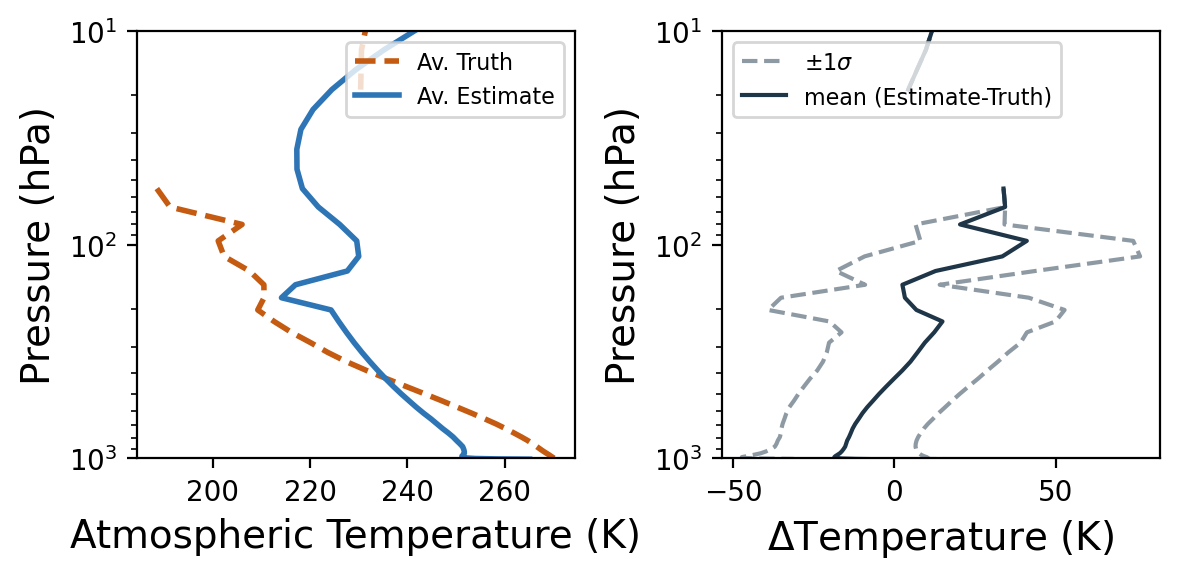

In [19]:
plot_T_profile_comparisons(ret_T, matchups['T'], matchups['pres'])

## Dealing with clouds
- The data we used to tarin our retrieval model was based on clear sky scenes. In the presence of cloud we are not able to retrieve profiles as we only see the emission from the cloud surface
- Because we have multiple channels we can create a basic cloud filter for the data based on a method used for old geostationary IR observations, which had fewer channels.
- If we use the WV (IRWV) and surface window (IRWIN) channels we can use the temperature diffence to estimate whether the scene is clear or not
- This method utuilises characteristics of the atmospheric lapse rate to make this estimate. In a clear sky scenario, the difference between IRWV and IRWIN should be negative as the surface is warmer than the air at higher altitudes. If cloud is present the difference approaches zero and in some cases goes slightly positive
- The threshold we use is anything colder than -25$^{\circ}$ is clear-sky

Lets look at the data ...

In [20]:
# calculate the difference between IRWV and IRWIN
cldfilt = matchups['bts'][:,11]-matchups['bts'][:,8] 

Text(0, 0.5, 'PDF')

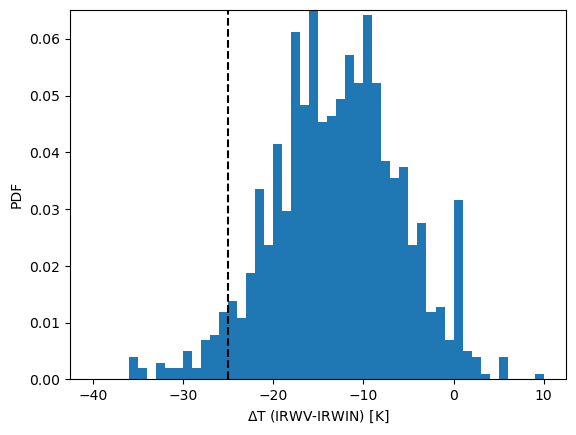

In [21]:
# Lets look at the distribution of the data
hist = plt.hist(cldfilt, bins=50, range=( -40, 10),density=True)
plt.plot([-25, -25],[0,hist[0].max()], '--k')
plt.ylim(0,hist[0].max())
plt.xlabel(r"$\Delta$T (IRWV-IRWIN) [K]")
plt.ylabel("PDF")

## What can we infer from this plot?

***
Lets apply our cloud filter to the data and see how it effects the results ...

C:\Users\tjt11.UOL\AppData\Local\Temp\ipykernel_16880\3420600491.py:13: RuntimeWarning: Mean of empty slice
  mu_dT = np.nanmean(dT, axis=0)
C:\Users\tjt11.UOL\AppData\Local\Temp\ipykernel_16880\3420600491.py:22: RuntimeWarning: Mean of empty slice
  plt.semilogy(np.nanmean(ref_T,axis=0), np.nanmean(p,axis=0),'--',lw=2,color='#C55A11',label=r'Av. Truth')


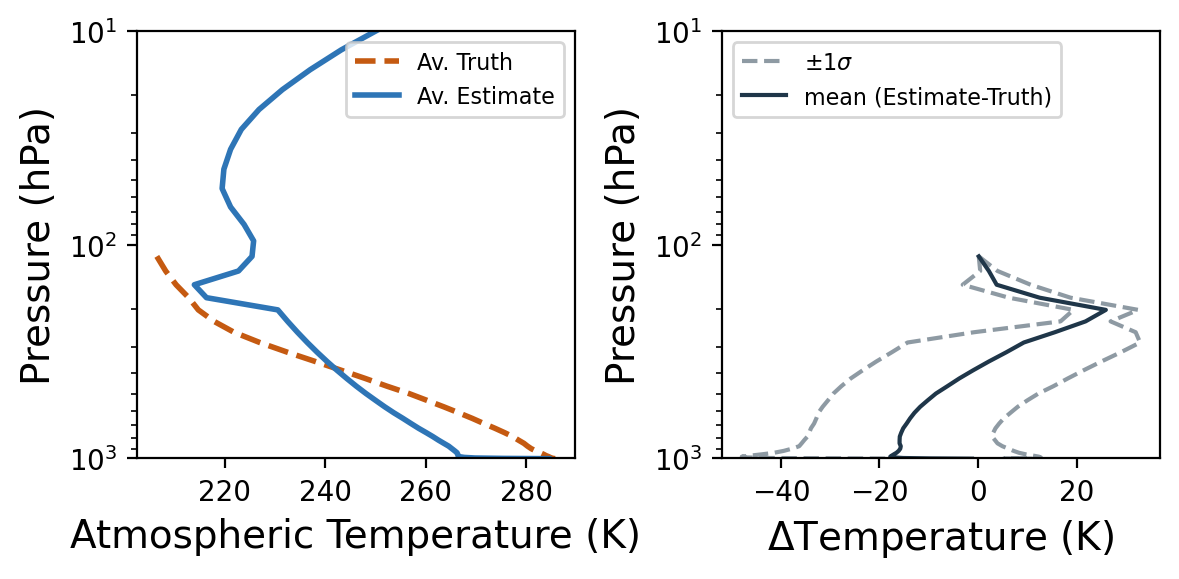

In [22]:
# create an indexing array using a where function to find clear scenes
mkr = np.where(cldfilt <= -25)
ret_T_cf = apply_linear_retrieval(Minv, Tmin, Tmax, matchups['bts'][:,ch_idx][mkr[0],:])
plot_T_profile_comparisons(ret_T_cf, matchups['T'][mkr[0],:], matchups['pres'][mkr[0],:])

# Experiment 2 Instructions:
### Read through all bullets first before proceeding. 
Now we have the validation results for clear-sky scenes, we can look again in more detail on how our inverse linear operator model computation impacts thge performance of our retrievals:
- Try a few further experiments where you alter the fraction of training data you use (0 to 1), and/or the number of channels (0-11). How does the validation result change?
- Overall, in plain language, how would you rate the performance of HIRS temperature profiles from this exersise?

### Extra tasks (if you have time)
- In a new cell can you adda calculation to determine the number and/or percentage of profiles dropped in the cloud filtering process
- can you restore a previous set of sampling indexes and rerun the model?
  **Hint**
  ```python
  # load the indexes from your prevous model 
  index = np.load('optimal_model_taining_data_sample_indexes.npy')

# Exersise 2: Extending our analysis of UTH time series with skin temperature data
![](img/cw3_delta_uth_timeseries_with_trends.png)

- last time we calculated time series of UTH from the from a lcimate data record you produced in the workshop
- Figure above shows results of the smoothed time series with linear trends fitted
- While we can see some varaiation over time, it is also helpful to know whether there are any impacts of temeprature change
- In the data folder you will find 3 files we are now going to work with:
![](img/workflow_step1_ex2.png)
  

- You will notice we have the csv file with the results from the previous worksho and 2 more.
- These two files starting pa260x_ecmwf are part of the dataset you will use for your coursework analysis, these two are of skin temperature and a land sea mask (all on 2x2 degrees)
- We will process them in a consistent way so that you can see how parts of code we have used in the past can be transfered for this exersise and your coursework assessment

![](img/new_notebook.png)

- we can begin by adding existing code and reproducing the time series plot of UTH
```python
import matplotlib.pyplot as plt
import numpy as np
import netCDF4

##################################################################################################
def read_csv(filename):
    """ read in the csv files we previously made of UTH anomaly time series.
    inputs: filename -> full path to file containing our data

    ouputs: results -> python dictionary containing our anomaly time series.
    """
    results = {}
    data = np.loadtxt(filename, skiprows=1, delimiter=",",dtype='<f4')
    header = np.genfromtxt(filename, delimiter=',', dtype=str, max_rows=1)
    for ii, varname in enumerate(header):
        results[varname] = data[:,ii]
    return results
    
##################################################################################################
def simple_moving_average(yvals, width):
    """ compute the moving average of a time series with a user defined sliding window.
    inputs: yvals -> time series on regular time steps
            width -> width of sliding window (n time steps)
    output: sommothed time series
    """
    return np.convolve(yvals, np.ones(width), 'same')/width
    
##################################################################################################
def estimate_coef(x, y):
    """ python implimentation of linear regression.
    Inputs: x -> 1D array (e.g. fractional year)
            y -> 1D array (e.g. UTH anomaly)

    Outputs: coeffs -> tuple containing the intercept and gradient
    """
    # define number of observations/points
    n = np.size(x)
    
    # calculate the mean of the x and y vectors
    m_x = np.mean(x)
    m_y = np.mean(y)
    
    # calculate cross-deviation and deviation about x
    SS_xy = np.sum(y*x) - n*m_y*m_x
    SS_xx = np.sum(x*x) - n*m_x*m_x
    
    # calculate regression coefficients
    b_1 = SS_xy / SS_xx
    b_0 = m_y - b_1*m_x
    return (b_0, b_1)


- you will notice this all code we have used before, just need to copy and paste it from a previous notebook
- Next we copy in the steps from last week to read the time series into memory and calculate the trends
  ```python
    ##################################################################################################
    # read in the data
    data = read_csv("PA2600/workshops/CW4/data/uth_anomoly_timeseries.csv")
    
    ##################################################################################################
    # apply a simple 12 month moving average filter to our time series.
    anom_sma_glb = simple_moving_average(data['Global'],12)
    anom_sma_lnd = simple_moving_average(data['Land'],12)
    anom_sma_ocn = simple_moving_average(data['Ocean'],12)
    
     ##################################################################################################
    # regress smoothed time series against fractional year and return linear fit coefficients
    glb_coeffs = estimate_coef(data['Frac_Year'], anom_sma_glb)
    lnd_coeffs = estimate_coef(data['Frac_Year'], anom_sma_lnd)
    ocn_coeffs = estimate_coef(data['Frac_Year'], anom_sma_ocn)
***
- The extra code we need for this task is to make the time series plot, which you can copy from here:
  ```python
    units=r" %/dec" 
    fig = plt.figure(num=1,figsize=(10,4),dpi=300)  
    plt.plot(data['Frac_Year'], anom_sma_glb,lw=2,color='#1F3649',label=f"Global ({glb_coeffs[1]*120:0.2f}{units})")
    yvalsg = glb_coeffs[0]+glb_coeffs[1]*data['Frac_Year']
    plt.plot(data['Frac_Year'], yvalsg, '--',color='#1F3649')
    
    plt.plot(data['Frac_Year'], anom_sma_lnd,lw=2,color="#2E75B6",label=f"Land ({lnd_coeffs[1]*120:0.2f}{units})")
    yvalsl = lnd_coeffs[0]+lnd_coeffs[1]*data['Frac_Year']
    plt.plot(data['Frac_Year'], yvalsl, '--',color="#2E75B6")
    
    plt.plot(data['Frac_Year'], anom_sma_ocn,lw=2,color="#C55A11",label=f"Ocean ({ocn_coeffs[1]*120:0.2f}{units})")
    yvalso = ocn_coeffs[0]+ocn_coeffs[1]*data['Frac_Year']
    plt.plot(data['Frac_Year'], yvalso, '--',color="#C55A11")
             
    plt.xlim(1979,2025)
    plt.ylim(-2.5,1.5)
    plt.ylabel(r"$\Delta$UTH (%)")
    plt.xlabel("year")
    plt.title(r"HIRS Clear Sky UTH 1979-2024 ($\pm$30$^{\circ}$)")
    plt.legend(loc=3)
    
    plt.tight_layout()

### At this point lets save our new notebook (give it a sensible name)
![](img/rename_notebbok_step1.png)
![](img/rename_notebbok_step2.png)

## Task 1: analysis of skin temperature between $\pm$30$^{\circ}$
- For this task we want to recreate the plots above skin temperature
- The next function we will need is <span style="color:blue">**read_gridded_data()**</span>

- then we can read in the two data files, set the report to either True or False to see what the contents are
  ``` python
    ###################################################################################################
    # step 1: read in the data
    era5_lsm_data = read_gridded_data("data/pa260x_ecmwf_Land_sea_mask_2.5_x_2.5_1940_2024.nc",report=False)
    era5_skt_data = read_gridded_data("data/pa260x_ecmwf_Skin_temperature_2.5_x_2.5_1940_2024.nc",report=True)

- Next we wantt o sample the data between +/- 30$^{\circ}$
    ```python
    ###################################################################################################
    # step 2: select data between +/-30, note here we use a where statement
    # with two conditions that need to be true so we use '&'
    find = np.where((era5_lsm_data['latitude'][:] >= -30)&(era5_lsm_data['latitude'][:] <= 30))
    
    # lets test with the land sea mask
    plt.figure(figsize=(12,2),dpi=200)
    plt.pcolormesh(era5_lsm_data['longitude'], era5_lsm_data['latitude'][find], era5_lsm_data['lsm'][find[0],:],vmin=0,vmax=1)
    plt.colorbar()

- Then we can subset the data to match our UTH dataset from last week and create a flag for land and ocean
    ```python
    ###################################################################################################
    # step 3: Now lets select our data from the two python dictoinaries so it is for our region of interest (ROI)
    lons = era5_lsm_data['longitude']
    lats = era5_lsm_data['latitude'][find]
    lsm = era5_lsm_data['lsm'][find[0],:]
    skt = era5_skt_data['skt'][:,find[0],:]
    # we can use use it to create a few masks for seperating land and ocean grid cells
    land = np.where(lsm == 1)
    ocean = np.where(lsm == 0)

- now create some weights for calculating the weighted time series data **NOTE** complete the balnk spaces in this code, balank are indicated with a question mark
    ```python
    ###################################################################################################
    # step 4: calculate the weights neededin our time series calculation
    # use meshgrid to create a 2D array of latitudes - we also get longitudes at the same time
    x2d, y2d = np.meshgrid(?,? )
    
    # calculate the weights
    wgts = np.cos(np.radians(?)
    
    # delete the data we now longer need
    del y2d,x2d

- The next step involves us reusing code from last week to calculate the time series of skin temeprature for global ,land andd ocean. You should be able to notice that the only chnage is in the array names which are called ```skt_ts_glb, skt_ts_lnd , skt_ts_ocn``` instead of uth_ts_glb, uth_ts_lnd , uth_ts_ocn. Copy the following code into your new notebook and fill in the balnks(blank == ?)
    ```python
    ###################################################################################################
    # step 5: define our arrays tohold the weighted mean skin temperature time series for each case
    tdim = era5_skt_data['time'].size
    skt_ts_glb = np.full(?, np.nan)
    skt_ts_lnd = np.full(?, np.nan)
    skt_ts_ocn = np.full(?, np.nan)
    
    # loop over each time step and andcalculated weighted mean UTH. In the case of the land and
    # ocean vaues we apply the masks calculated previously
    for tt, tmp in enumerate(skt):
        mdx = tt % 12
        skt_ts_glb[tt] = np.nansum(tmp*wgts)/np.nansum(wgts)
        skt_ts_lnd[tt] = np.nansum(tmp[?]*wgts[?])/np.nansum(wgts[?])
        skt_ts_ocn[tt] = np.nansum(tmp[?]*wgts[?])/np.nansum(wgts[?])
    
    # make a simple plot of the results
    plt.figure(figsize=(8,3),dpi=300)
    plt.plot(era5_skt_data['time'], skt_ts_glb, label='Global')
    plt.plot(era5_skt_data['time'], skt_ts_lnd, label='Land')
    plt.plot(era5_skt_data['time'], skt_ts_ocn, label='Ocean')
    plt.xlim(1940,2025)
    plt.legend(loc=4)

- Now we take the same idea and reuse the code from last week to calculate the anomoly timeseries. The main change here is that the time series runs from 1940. Copy the following code into your new notebook and fill in the balnks(blank == ?)
    ```python
    ###################################################################################################
    # step 6: calculate the anomaly time series and plot
    # define ourr arrays
    anom_glb = np.full(tdim, np.nan)
    anom_lnd = np.full(tdim, np.nan)
    anom_ocn = np.full(tdim, np.nan)
    
    # we will use a 20 year reference period between 1980 to 2000
    ref_time = np.where((era5_skt_data['time'] >= 1980)&(era5_skt_data['time'] < 2001))
    
    # loop over each month step between 0-11 and calculate the anomaly
    for mth in range(12):
        anom_glb[mth::12] = skt_ts_glb[mth::12] - np.nanmean(skt_ts_glb[ref_time][mth::12])
        anom_lnd[mth::12] = skt_ts_lnd[mth::12] - np.nanmean(skt_ts_lnd[ref_time][mth::12])
        anom_ocn[mth::12] = skt_ts_ocn[mth::12] - np.nanmean(skt_ts_ocn[ref_time][mth::12])
    
    # make a simple plot
    plt.figure(figsize=(8,3),dpi=300)
    plt.plot(era5_skt_data['time'], anom_glb, label='Global')
    plt.plot(era5_skt_data['time'], anom_lnd, label='Land')
    plt.plot(era5_skt_data['time'], anom_ocn, label='Ocean')
    plt.xlim(1940,2025)
    plt.legend(loc=4)

## Note: if you want to save yopur time series remeber we can use this code:
```python 
# This our code to save the outputs
# we open a file called uth_anomoly_timeseries.csv and assign it to a file object we have named fobj
# we can the loop over each time step and write the results to file
with open("skt_anomoly_timeseries_pm30_deg.csv", "w") as fobj:
    # first we write a header, the \n tells the computer to start a new line
    fobj.write("Frac_Year,Global,Land,Ocean\n")
    # here we use zip in order to interate over all arrays at the same time
    for yr, v1, v2, v3 in zip(era5_skt_data['time'], anom_glb,anom_lnd,anom_ocn):
        # we create a f string and write it to file
        fobj.write(f"{yr:0.3f}, {v1:0.2f}, {v2:0.2f}, {v3:0.2f}\n")

- next stage is to apply the smoothing filter to the time series, again complete tthe code below and add it to your new notebook
```python
    ##################################################################################################
    # step7: apply a simple 12 month moving average filter to our time series.
    skt_anom_sma_glb = simple_moving_average(?,12)
    skt_anom_sma_lnd = simple_moving_average(?,12)
    skt_anom_sma_ocn = simple_moving_average(?,12)

- Now we have some new timeseries we can do a couple of things:
  1. produce scatter plots of skin temperature vs. UTH
  2. calculate the linear fit between skin tempearure and UTH
  3. calculate the pearson correlation between the two time series

  ```python
    # you need this scipy library - add to top of notebook
    from scipy import stats
    ##################################################################################################
    # step 7: select the same time period for analysis 
    mkr = np.where((era5_skt_data['time'] >= 1979)&(era5_skt_data['time'] <= 2025))
    
    
    # regress smoothed time series against fractional year and return linear fit coefficients
    g_coeffs = estimate_coef(skt_anom_sma_glb[mkr], anom_sma_glb)
    l_coeffs = estimate_coef(skt_anom_sma_lnd[mkr], anom_sma_lnd)
    o_coeffs = estimate_coef(skt_anom_sma_ocn[mkr], anom_sma_ocn)
    
    # calculate the pearson coeeficients
    rg = stats.pearsonr(skt_anom_sma_ocn[mkr], anom_sma_ocn)
    rl = stats.pearsonr(skt_anom_sma_lnd[mkr], anom_sma_lnd)
    ro = stats.pearsonr(skt_anom_sma_glb[mkr], anom_sma_glb)
    
    # convert pearson coefficient to a string and add a * if significant
    if rg[1] < 0.05:
        rgs = f"{rg[0]:0.2f}*"
    else:
        rgs = f"{rg[0]:0.2f}"
    
    if rl[1] < 0.05:
        rls = f"{rl[0]:0.2f}*"
    else:
        rls = f"{rl[0]:0.2f}"
    
    if ro[1] < 0.05:
        ros = f"{ro[0]:0.2f}*"
    else:
        ros = f"{ro[0]:0.2f}"
    
    # make a simple set of scatter plots of skin temp vs UTH
    plt.figure(figsize=(9,3),dpi=200)
    plt.subplot(131)
    plt.plot(skt_anom_sma_glb[mkr], anom_sma_glb, 'o',label=f"{g_coeffs[0]:0.2f} %/K")
    plt.ylabel(r"$\Delta$UTH (%)")
    plt.xlabel(r"$\Delta$T$_{s}$ (K)")
    plt.title(f'Global (r={rgs})')
    plt.legend()
    
    plt.subplot(132)
    plt.plot(skt_anom_sma_ocn[mkr], anom_sma_ocn, 'o',label=f"{o_coeffs[0]:0.2f} %/K")
    plt.ylabel(r"$\Delta$UTH (%)")
    plt.xlabel(r"$\Delta$T$_{s}$ (K)")
    plt.title(f'Ocean (r={ros})')
    plt.legend()
    
    plt.subplot(133)
    plt.plot(skt_anom_sma_lnd[mkr], anom_sma_lnd, 'o',label=f"{l_coeffs[0]:0.2f} %/K")
    plt.ylabel(r"$\Delta$UTH (%)")
    plt.xlabel(r"$\Delta$T$_{s}$ (K)")
    plt.title(f'Land (r={rls})')
    plt.legend()
    plt.tight_layout()
  

## take some to look at these results? What do they mean?
***

# The El Niño Southern Oscillation (ENSO)
The El Niño-Southern Oscillation (ENSO) is a recurring climate pattern involving changes in the temperature of waters in the central and eastern tropical Pacific Ocean. On periods ranging from about three to seven years, the surface waters across a large swath of the tropical Pacific Ocean warm or cool by anywhere from 1°C to 3°C, compared to normal. This oscillating warming and cooling pattern, referred to as the ENSO cycle, directly affects rainfall distribution in the tropics and can have a strong influence on weather across the United States and other parts of the world. El Niño and La Niña are the extreme phases of the ENSO cycle; between these two phases is a third phase called ENSO-neutral.

![](img/enso_1.png)
***

![](img/enso_2.png)
***

![](img/enso_3.png)
***

![](img/enso_4.png)
***

- With this notebook there is another called enso_tools.ipnb which has some code to calculate ENSO SST anomolies
- we can load the function into our jupyter notebook instead of copying everything over using the magic ```%run ``` command
- the function we will use from this notebook is called <span style="color:blue">**create_enso_timeseries()**</span>
- it will calculate time series for the 5 ENSO regions highlighted below

![](img/enso_regions.png)

- to do all this we will need the following code
    ```python
    ##################################################################################################
    # step 8: Calculate ENSO anomolies and test their correlation against UTH anomolies
    # load the functions from enso_tools.ipynb
    %run enso_tools
    
    # calculate the SST anaomolies for ENSO regions
    sst_anoms = create_enso_timeseries(skt, lats, lons, lsm)

- Our final test is to see whetether the UTH correlates any differently to the ENSO anomolies
- We can automate this with a function (added to the top of our notebook along with all the other functions):
  ```python
  def calc_peason_r(sst_anoms, anom_sma_ocn, anom_sma_lnd, anom_sma_glb, mkr):
    """ have a go at writing the header for this function - do you know hat it is doing?
    """
    nreg = 4
    nuth = 3
    corr = np.full((4,3),0.0)
    sigf = np.full((4,3),0.0)
    timeseries = [anom_sma_ocn, anom_sma_lnd, anom_sma_glb]
    for jj, reg in enumerate(sst_anoms.keys()):
        for ii, ts in enumerate(timeseries):
            result = stats.pearsonr(sst_anoms[reg][mkr], ts)
            corr[jj,ii] = result[0]
            sigf[jj,ii] = result[1]
    
    table = []
    table.append(["ENSO region", "UTH Ocean", "UTH Land", "UTH Global"])
    for (r1, r2,reg) in zip(corr, sigf, sst_anoms.keys()):
        line = [reg]
        for v1, v2 in zip(r1, r2):
            if v2 < 0.05:
                res = f"{v1:0.2f}*"
            else:
                res = f"{v1:0.2f}"
            line.append(res)
        table.append(line)
    print(np.array(table))
***
- Then to calculate the results we can just run this function and it will print a simple table to screen:
    ```python
    # calculate pearson corrleations and print a simple table to screen
    calc_peason_r(sst_anoms, anom_sma_ocn, anom_sma_lnd, anom_sma_glb, mkr)

![](img/workshop_summary.png)